In [19]:
import warp as wp
import numpy as np
import trimesh

from warp.sim.collide import TriMeshCollisionDetector

import glob
from os.path import join
import numpy as np

In [12]:
data_path = r"Data"

shape_pre_initialization_files = sorted(glob.glob(join(data_path, "step_*_pre_initialization_shape.ply")))
displacement_initialization_files = sorted(glob.glob(join(data_path, "step_*_initialization_displacement.npy")))

shape_pre_iteration_files = sorted(glob.glob(join(data_path, "step_*_iter_*_shape.ply")))
displacement_iteration_files = sorted(glob.glob(join(data_path, "step_*_iter_*_displacement.npy")))


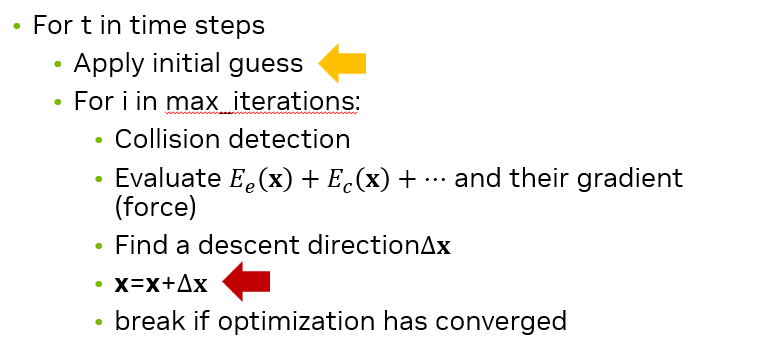
- shape_pre_initialization: shapes before the initialization stage (yellow arrow)
- displacement_initialization_files: displacements of the initialization state (yellow arrow)
- shape_pre_iteration_files: shape before each iteration (red arrow)
- displacement_iteration_files: displacements of each iteration (red arrow)

In [16]:
device = wp.get_device('cuda')
# if you don't have a CUDA-compatible GPU try switching to CPU
# device = wp.get_device('cpu')

Warp 1.8.0 initialized:
   CUDA Toolkit 12.5, Driver 12.6
   Devices:
     "cpu"      : "AMD64 Family 25 Model 97 Stepping 2, AuthenticAMD"
     "cuda:0"   : "NVIDIA GeForce RTX 4090" (24 GiB, sm_89, mempool enabled)
   Kernel cache:
     C:\Users\ankac\AppData\Local\NVIDIA\warp\Cache\1.8.0


In [20]:
mesh_pre_init = trimesh.load(shape_pre_initialization_files[0])
displacement_init = np.load(displacement_initialization_files[0])

In [22]:
builder = wp.sim.ModelBuilder()

vertices = [wp.vec3(mesh_pre_init.vertices[i,:]) for i in range(mesh_pre_init.vertices.shape[0])]
builder.add_cloth_mesh(
            pos=wp.vec3(0.0, 0.0, 0.0),
            rot=wp.quat_identity(),
            scale=1.0,
            vertices=vertices,
            indices=mesh_pre_init.faces.reshape(-1),
            vel=wp.vec3(0.0, 0.0, 0.0),
            density=0.02,
            tri_ke=1.0e5,
            tri_ka=1.0e5,
            tri_kd=2.0e-6,
            edge_ke=10,
)
builder.color()
model = builder.finalize()

Warp UserWarning: The graph is not optimizable anymore, terminated with a max/min ratio: 2.0 without reaching the target ratio: 1.1
Module warp.sim.graph_coloring 3c9ae71 load on device 'cpu' took 13.30 ms  (cached)


In [33]:
# to access ForceElementAdjacencyInfo, you need to construct a VBDIntegrator (you dont need to understand what it is)
vbd_integrator = wp.sim.VBDIntegrator(model)
collision_detector = TriMeshCollisionDetector(model)

In [34]:
collision_detector.vertex_triangle_collision_detection(5.0)
collision_detector.edge_edge_collision_detection(5.0)

In [35]:
# TODO: compute the conservative bounds

In [36]:
# TODO: truncate the displacement
# replace this with actual truncation
new_pos = wp.array(mesh_pre_init.vertices + displacement_init, dtype=wp.vec3, device=device)

In [41]:
# must include this after you update the mesh position, otherwise the collision detection results are not precise
collision_detector.refit(new_pos)
collision_detector.triangle_triangle_intersection_detection()

# TODO: analysis the results to see if there is an intersection
# NOTE that the triangle-triangle intersection test applied in triangle_triangle_intersection_detection() is single precision
# You need to implement a double-precision version yourself to see if it actually intersects. It can be a python code or warp kernel, both are okay

In [42]:
# TODO: Make this automated and process through all the files

In [ ]:
# Bonus: implement double precision tri-tri intersection narrow phase test
# in line 2145 of the warp/sim/collide.py, there is a call of the built-in tri-tri intersection implemented in single precision
#         if wp.intersect_tri_tri(v1, v2, v3, u1, u2, u3):
# You can replace it with a double-precision version, to make your intersection more robust
# you can use @wp.func to implement a subsitute
